# **Capitulo 3 – Dimensionality Reduction**

# Setup

Como hicimos en Notebooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/dim_reduction` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [7]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # inicializar el conjunto de datos 3D
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # distribución desigual
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # añadir más ruido
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # cambiar un poco

# LLE

La incrustación lineal local (LLE) es una técnica de reducción no lineal de la dimensionalidad (NLDR). Es una técnica de aprendizaje manifold que no se basa en proyecciones, a diferencia del PCA y la proyección aleatoria. En pocas palabras, LLE funciona midiendo en primer lugar cómo se relaciona linealmente cada instancia de entrenamiento con sus vecinos más cercanos y, a continuación, buscando una representación de baja dimensión del conjunto de entrenamiento en la que estas relaciones locales se conserven mejor. Este enfoque lo hace especialmente bueno para desenrollar variedades retorcidas, sobre todo cuando no hay demasiado ruido.

El siguiente código crea un rollo suizo y utiliza la clase ding LocallyLinearEmbed de Scikit-Learn para desenrollarlo:

In [1]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

La variable t es un array NumPy 1D que contiene la posición de cada instancia a lo largo del eje rodado del rollo suizo. No la utilizamos en este ejemplo, pero puede usarse como objetivo para una tarea de regresión no lineal.

En la siguiente Figura se muestra el conjunto de datos 2D resultante. Como puede verse, el rollo suizo está completamente desenrollado, y las distancias entre instancias están localmente bien conservadas.

Sin embargo, las distancias no se conservan a mayor escala: el rollo suizo desenrollado debería ser un rectángulo, no este tipo de banda estirada y retorcida. No obstante, LLE ha hecho un buen trabajo modelando el manifold.

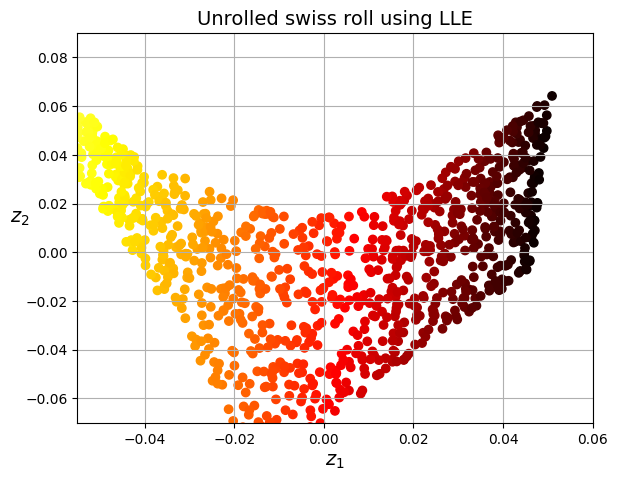

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.title("Unrolled swiss roll using LLE")
plt.show()


Así es como funciona el LLE: para cada instancia de entrenamiento $x^(i)$ , el algoritmo identifica sus k vecinos más cercanos (en el código anterior k = 10), luego intenta reconstruir $x^{(i)}$ como una función lineal de estos vecinos. Más concretamente, trata de encontrar los pesos $w_{i,j}$ tal que la distancia al cuadrado entre $x^{(i)}$ y $\sum_{j=1}^{m} w_{i,j}x^j$ sea lo más pequeña posible, suponiendo $w_{i,j} = 0 si x (j)$ no es uno de los k-vecinos más cercanos de $x^{(i)}$ . Así, el primer paso de LLE es el problema de optimización con restricciones, donde W es la matriz de pesos que contiene todos los pesos $w_{i,j}$. La segunda restricción simplemente normaliza los pesos para cada instancia de entrenamiento $x^{(i)}$.

La implementación LLE de Scikit-Learn tiene la siguiente complejidad computacional: $O(m log(m)n log(k))$ para encontrar los k vecinos más cercanos, $O(mnk^3)$ para optimizar los pesos, y $O(dm^2)$ para construir las representaciones de baja dimensión. Desgraciadamente, el m^2 del último término hace que este algoritmo no se adapte bien a conjuntos de datos muy grandes. Como se puede ver, LLE es bastante diferente de las técnicas de proyección, y es significativamente más complejo, pero también puede construir representaciones de baja dimensión mucho mejores, especialmente si los datos son no lineales.

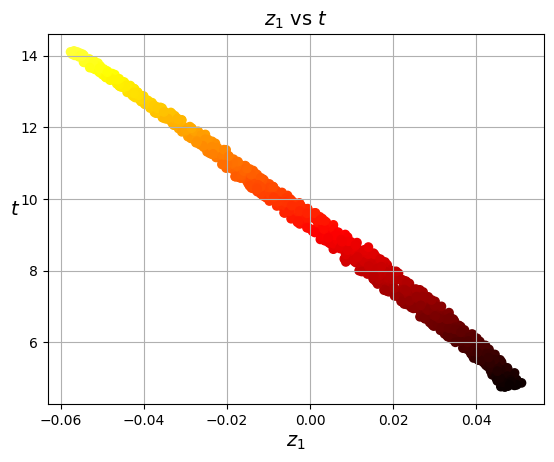

In [9]:
# muestra lo bien correlacionado que está z1 con t: LLE funcionó bien
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

Nota: se añadió `normalized_stress=False` a continuación para evitar una advertencia sobre el hecho de que el valor por defecto para ese hiperparámetro cambiará en el futuro. Por favor, consulte la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) para más detalles.

# Otras técnicas de reducción de la dimensionalidad

Antes de concluir este Notebook, echemos un vistazo rápido a otras técnicas populares de reducción de la dimensionalidad disponibles en Scikit-Learn:

- sklearn.manifold.MDS

El escalado multidimensional (MDS) reduce la dimensionalidad a la vez que intenta preservar las distancias entre las instancias. La proyección aleatoria lo hace para datos de alta dimensión, pero no funciona bien en datos de baja dimensión.

- sklearn.manifold.Isomap

Isomap crea un grafo conectando cada instancia a sus vecinos más cercanos, luego reduce la dimensionalidad mientras intenta preservar las distancias geodésicas entre las instancias. La distancia geodésica entre dos nodos en un grafo es el número de nodos en el camino más corto entre estos nodos.

- sklearn.manifold.TSNE

t-distributed stochastic neighbor embedding (t-SNE) reduce la dimensionalidad a la vez que intenta mantener las instancias similares cerca y las instancias disímiles separadas. Se utiliza principalmente para la visualización, en particular para visualizar grupos de instancias en un espacio de alta dimensión. Por ejemplo, en los ejercicios del final de este NoteBook utilizará t-SNE para visualizar un mapa 2D de las imágenes MNIST.

- sklearn.discriminant_analysis.LinearDiscriminantAnalysis

El análisis discriminante lineal (LDA) es un algoritmo de clasificación lineal que, durante el entrenamiento, aprende los ejes más discriminativos entre las clases. Estos ejes pueden utilizarse para definir un hiperplano sobre el que proyectar los datos. La ventaja de este enfoque es que la proyección mantendrá las clases lo más separadas posible, por lo que el LDA es una buena técnica para reducir la dimensionalidad antes de ejecutar otro algoritmo de clasificación (a menos que el LDA por sí solo sea suficiente).


In [10]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [11]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

La siguiente Figura muestra los resultados de MDS, Isomap y t-SNE en el rollo suizo. MDS consigue aplanar el rollo suizo sin perder su curvatura global, mientras que Isomap la elimina por completo. Dependiendo de la tarea posterior, preservar la estructura a gran escala puede ser bueno o malo. t-SNE hace un trabajo razonable aplanando el rollo suizo, preservando un poco de curvatura, y también amplifica los clusters, desgarrando el rollo. Una vez más, esto puede ser bueno o malo, dependiendo de la tarea posterior.


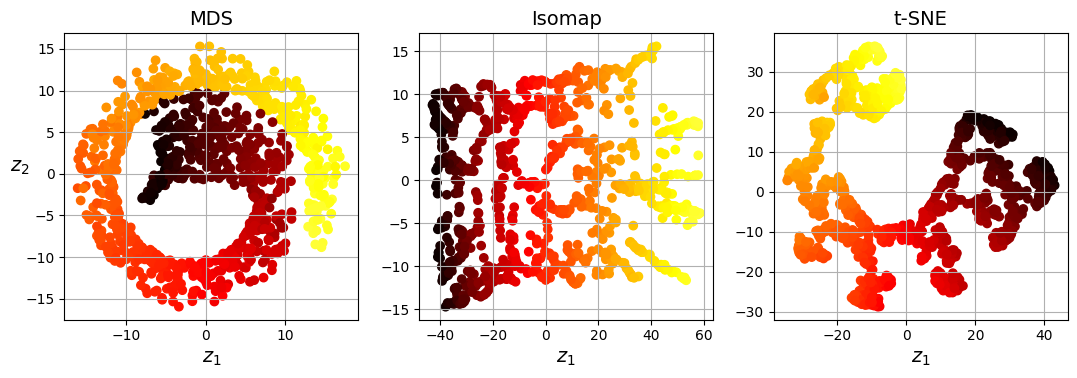

In [13]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

# Extra Material – Kernel PCA

In [14]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

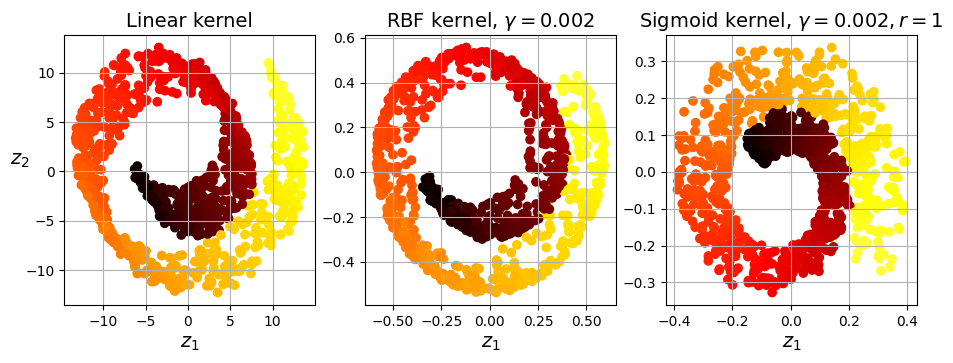

In [15]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "Linear kernel"),
               (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"Sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

plt.show()